In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
path = "/content/drive/MyDrive/AI_ML_Projects/Electric_Load_Forecasting_Purely_Time_Series_Demo_Project/dipam/spain_energy_market.csv"
data = pd.read_csv(path, sep=",", parse_dates=["datetime"])
data = data[data["name"]=="Demanda programada PBF total"]
data['date'] = pd.to_datetime(data['datetime']).dt.normalize()
#data["date"] =data["datetime"].dt.date
data.set_index("date",inplace = True)
data = data[["value"]]
#data = data.asfreq("D")
#data = data.rename(columns={"value": "energy"})
#data = data.drop(['id','name','geoid','geoname'],axis =1)
data.head(5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,value
date,
2014-01-01,620107.7
2014-01-02,659865.2
2014-01-03,632536.8
2014-01-04,610251.7
2014-01-05,572534.1


In [4]:
days = 35
forecast = 28

In [5]:
#X_train = data.iloc[0:-30,:]
X_test = data.iloc[-(days+forecast):,:]
#y_origin = data.iloc[-1:,:]
#print(X_train.tail())
x_train = data['value'].values
print(x_train)
print(X_test)
#print(y_origin)
x_test = X_test['value'].values
#y_origin = y_origin['value'].values
#x_test = X_test['value'].tolist()
print(x_test)
y_origin = x_test[-forecast:]
print(y_origin)
x_test = x_test[:-forecast]
print(x_test)
#print(np.count_nonzero(x_train))

[620107.7 659865.2 632536.8 ... 602541.7 574254.2 597701.2]
               value
date                
2018-10-29  676119.8
2018-10-30  676231.7
2018-10-31  571942.2
2018-11-01  627860.2
2018-11-02  597407.9
...              ...
2018-12-26  649103.9
2018-12-27  639571.2
2018-12-28  602541.7
2018-12-29  574254.2
2018-12-30  597701.2

[63 rows x 1 columns]
[676119.8 676231.7 571942.2 627860.2 597407.9 563281.7 677638.3 702392.7
 704401.6 687658.  660520.3 614431.4 569407.6 669656.8 681256.5 692971.2
 686835.3 671507.9 611657.2 568718.6 674977.6 703811.6 719100.9 712368.1
 710996.3 625322.3 588791.2 697420.3 721354.5 734391.2 711439.6 702207.
 642247.2 597570.6 685913.4 697872.  688046.4 609466.9 649482.1 609660.8
 591087.6 700153.2 713930.4 724397.  731645.7 723897.  657183.1 614771.8
 727126.8 741257.1 727532.5 718927.8 696422.1 624097.1 585545.9 596095.6
 527281.8 612702.5 649103.9 639571.2 602541.7 574254.2 597701.2]
[697872.  688046.4 609466.9 649482.1 609660.8 591087.6 700153.2 71393

In [6]:
x_train = x_train.reshape(-1,1)
x_test = x_test.reshape(-1,1)
y_origin = y_origin.reshape(-1,1)
print(x_train.shape)

(1825, 1)


In [7]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [8]:
scaler = MinMaxScaler(feature_range = (0, 1))
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)
y_origin = scaler.fit_transform(y_origin)

In [9]:
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import Dropout
 
# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the sequence
		if out_end_ix > len(sequence):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)
 
# define input sequence
#raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]
# choose a number of time steps
n_steps_in, n_steps_out = 35, 28
# split into samples
X, y = split_sequence(x_train, n_steps_in, n_steps_out)
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
y = y.reshape((y.shape[0], y.shape[1], n_features))
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_steps_in, n_features)))
model.add(RepeatVector(n_steps_out))
model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(1)))
model.compile(optimizer='adam', loss='mean_squared_error')
# fit model
stats = model.fit(X, y, epochs=200, batch_size = 64, validation_split=0.1, validation_batch_size=32)


Epoch 1/200
25/25 [==============================] - 5s 100ms/step - loss: 0.0958 - val_loss: 0.0385
Epoch 2/200
25/25 [==============================] - 2s 81ms/step - loss: 0.0438 - val_loss: 0.0327
Epoch 3/200
25/25 [==============================] - 2s 82ms/step - loss: 0.0381 - val_loss: 0.0289
Epoch 4/200
25/25 [==============================] - 2s 79ms/step - loss: 0.0359 - val_loss: 0.0277
Epoch 5/200
25/25 [==============================] - 2s 81ms/step - loss: 0.0344 - val_loss: 0.0266
Epoch 6/200
25/25 [==============================] - 2s 83ms/step - loss: 0.0337 - val_loss: 0.0261
Epoch 7/200
25/25 [==============================] - 2s 80ms/step - loss: 0.0330 - val_loss: 0.0252
Epoch 8/200
25/25 [==============================] - 2s 80ms/step - loss: 0.0326 - val_loss: 0.0248
Epoch 9/200
25/25 [==============================] - 2s 82ms/step - loss: 0.0322 - val_loss: 0.0250
Epoch 10/200
25/25 [==============================] - 2s 82ms/step - loss: 0.0321 - val_loss: 0.024

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 repeat_vector (RepeatVector  (None, 28, 100)          0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 28, 100)           80400     
                                                                 
 time_distributed (TimeDistr  (None, 28, 1)            101       
 ibuted)                                                         
                                                                 
Total params: 121,301
Trainable params: 121,301
Non-trainable params: 0
_________________________________________________________________


In [11]:
x_input = x_test.reshape((1, n_steps_in, n_features))
yhat = model.predict(x_input)
print(yhat)

[[[0.6988976 ]
  [0.6885766 ]
  [0.6930753 ]
  [0.68936944]
  [0.44523194]
  [0.25685182]
  [0.59701467]
  [0.69420993]
  [0.66793454]
  [0.6875688 ]
  [0.68700224]
  [0.50785404]
  [0.30885163]
  [0.6320157 ]
  [0.66554654]
  [0.68164134]
  [0.6752425 ]
  [0.64539206]
  [0.46975225]
  [0.29354137]
  [0.59413135]
  [0.6285782 ]
  [0.6575125 ]
  [0.65552926]
  [0.6247842 ]
  [0.46864626]
  [0.28691602]
  [0.56991875]]]


In [12]:
print(yhat.shape)

(1, 28, 1)


In [13]:
Y_test = y_origin.reshape(y_origin.shape[0], y_origin.shape[1])
predicted_values = yhat.reshape(yhat.shape[0], yhat.shape[1])

predicted_values = scaler.inverse_transform(predicted_values)
Y_test = scaler.inverse_transform(Y_test)

In [14]:
print(predicted_values)
print(Y_test)

[[676828.6  674620.2  675582.8  674789.9  622550.44 582241.75 655028.2
  675825.56 670203.3  674404.5  674283.3  635950.   593368.4  662517.56
  669692.3  673136.25 671767.   665379.75 627797.2  590092.4  654411.25
  661782.   667973.25 667548.9  660970.2  627560.56 588674.75 649230.3 ]]
[[697872. ]
 [688046.4]
 [609466.9]
 [649482.1]
 [609660.8]
 [591087.6]
 [700153.2]
 [713930.4]
 [724397. ]
 [731645.7]
 [723897. ]
 [657183.1]
 [614771.8]
 [727126.8]
 [741257.1]
 [727532.5]
 [718927.8]
 [696422.1]
 [624097.1]
 [585545.9]
 [596095.6]
 [527281.8]
 [612702.5]
 [649103.9]
 [639571.2]
 [602541.7]
 [574254.2]
 [597701.2]]


In [15]:
import numpy as np
Y_test = Y_test.reshape(28,1)
predicted_values= predicted_values.reshape(28,1)
print(predicted_values.shape)
print(Y_test.shape)
mean_squared_error_array=[]
for i in range(7):
    mean_squared_error_array.append(mean_squared_error(Y_test[i],predicted_values[i]))

root_mean_squared_error_array = np.sqrt(np.array(mean_squared_error_array))

print("Median Root Mean Squared Error: ",np.median(root_mean_squared_error_array))
print("Accuracy Based on Median RMSE ",100-((np.median(root_mean_squared_error_array)/np.max(Y_test))*100))

print("Max Root Mean Squared Error: ",np.max(root_mean_squared_error_array))
print("Accuracy Based on Max RMSE ",100-((np.max(root_mean_squared_error_array)/np.max(Y_test))*100))

(28, 1)
(28, 1)
Median Root Mean Squared Error:  21043.375
Accuracy Based on Median RMSE  97.1611233133551
Max Root Mean Squared Error:  66115.91249999998
Accuracy Based on Max RMSE  91.0805694137702


In [16]:
print(Y_test[0])
print(predicted_values[0])

[697872.]
[676828.6]


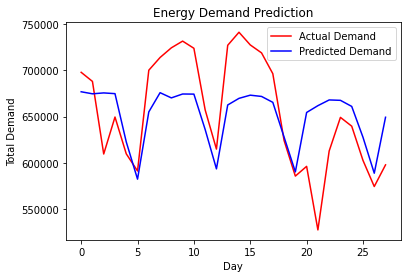

In [17]:
import matplotlib.pyplot as plt
#for i in range(forecast):
plt.plot(Y_test, color = 'red', label = 'Actual Demand')
plt.plot(predicted_values, color = 'blue', label = 'Predicted Demand')
plt.title('Energy Demand Prediction')
plt.xlabel('Day')
plt.ylabel('Total Demand')
plt.legend()
plt.show()